# Refresh data from OneDrive
Data is stored in <br>
`D:\onedrive\guigui perso\Zoé` <br>
1st step is to copy to <br> 
`D:\git\data-scientist-skills\python-sandbox\zoe\data`

In [1]:
%reload_ext autoreload
%autoreload 2

On copie le fichier kilometrage de onedrive dans le rep de travail.

In [2]:
filename="kilométrage.xlsx"

# importing os module  
import os 
  
# importing shutil module  
import shutil 
  
# path 
path = 'D:\onedrive\MFP Michelin\guigui perso - Documents\Zoé'
  
# List files and directories 
# in '/home/User/Documents' 
print("Before copying file:") 
print(os.listdir(path)) 
  
  
# Source path 
source = path+"/"+filename
  
# Destination path 
destination = "D:\git\data-scientist-skills\python-sandbox\zoe\data/"+filename
  
# Copy the content of 
# source to destination 
dest = shutil.copyfile(source, destination) 
  
# List files and directories 
# in "/home / User / Documents" 
print("After copying file:") 
print(os.listdir(path)) 
  
# Print path of newly  
# created file 
print("Destination path:", dest) 

import datetime
print(datetime.datetime.now())       

Before copying file:
['kilométrage.xlsx']
After copying file:
['kilométrage.xlsx']
Destination path: D:\git\data-scientist-skills\python-sandbox\zoe\data/kilométrage.xlsx
2020-01-21 07:50:15.617599


Data should now be in 
[data](data/)

Load kilometrage in dataframe, avec la colonne de date en index

In [3]:
import pandas as pd
import numpy as np
filename='data/kilométrage.xlsx'
data=pd.read_excel(filename, names=["date", "kms"],parse_dates=True, index_col=0)
data.tail()

,kms
date,
2019-12-05,1880
2019-12-16,2393
2019-12-29,2595
2020-01-10,2888
2020-01-21,3180


Créer un range de data entre le 1er jour et aujourd'hui <br>
En faire un index (sans compléter les valeurs)

In [4]:
to_date_rng = pd.date_range(start='09/27/2019', end = pd.datetime.today(), freq='D')
#print(to_date_rng)
#print(data.reindex(to_date_rng, method='pad'))
data=data.reindex(to_date_rng)

Plot curve : on visualise les kms effectivement faits, en rouge les données manquantes extrapolées linéairement

In [5]:
def extend_missing(missing):
    missing_array=missing.values
    new_missing=missing_array.copy()
    for i in range(len(missing_array)-1):
        if ((~missing_array[i]) & (missing_array[i+1])):
            new_missing[i]=True
        if ((missing_array[i]) & (~missing_array[i+1])):
            new_missing[i+1]=True
    df_new_missing=pd.DataFrame(new_missing)
    df_new_missing['index']=missing.index
    df_new_missing.set_index('index', inplace=True)
    df_new_missing.columns=missing.columns
    return df_new_missing

missing_values = data.isna()
print(extend_missing(missing_values).head())

              kms
index            
2019-09-27  False
2019-09-28  False
2019-09-29   True
2019-09-30   True
2019-10-01   True


On affiche les kms parcourus et en rouge une droite reliant les valeurs connues

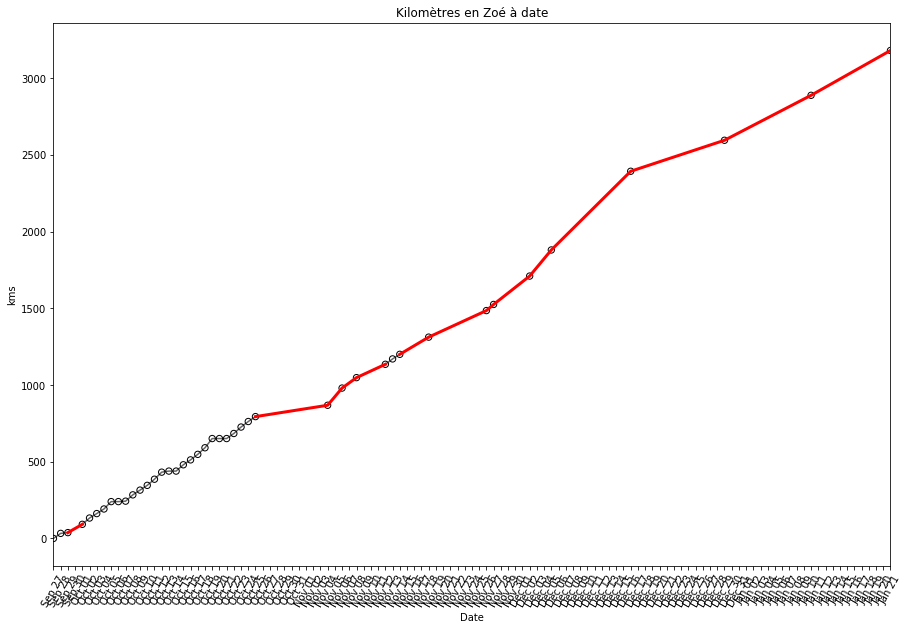

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
#The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters
#To register the converters:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Create a function we'll use to interpolate and plot
def interpolate_and_plot(data, interpolation, title='No title'):

    # Create a boolean mask for missing values
    missing_values = data.isna()
    # Extend this mask with extend_missing
    new_missing=extend_missing(missing_values)

    # Interpolate the missing values
    data_interp = data.interpolate(interpolation)

    # Plot the results
    fig, ax = plt.subplots(figsize=(15, 10))
    
    #en noir les valeurs connues
    data_interp[~missing_values].plot(color='k', alpha=.6, ax=ax, legend=False)
    plt.scatter(data_interp[~missing_values].index, data_interp[~missing_values],s=40,facecolors='none', edgecolors='k')
    
    plt.xlabel('Date')
    date_enX=data.index[::1] # tous les 1 jours
    labels_date=date_enX.strftime('%b %d') # mois et jour

    plt.ylabel(list(data.columns)[0])
    plt.title(title)
    
    # Now plot the interpolated values on top in red
    data_interp[new_missing].plot(ax=ax, color='r', lw=3, legend=False)

    plt.xticks(date_enX,labels_date,rotation=60)
    plt.show()

# Interpolate linearly
interpolation_type = 'linear'
interpolate_and_plot(data, interpolation_type, title='Kilomètres en Zoé à date')

# Interpolate the missing values
data_interp = data.interpolate(interpolation_type)


In [7]:
data_interp[~missing_values].index

DatetimeIndex(['2019-09-27', '2019-09-28', '2019-09-29', '2019-09-30',
               '2019-10-01', '2019-10-02', '2019-10-03', '2019-10-04',
               '2019-10-05', '2019-10-06',
               ...
               '2020-01-12', '2020-01-13', '2020-01-14', '2020-01-15',
               '2020-01-16', '2020-01-17', '2020-01-18', '2020-01-19',
               '2020-01-20', '2020-01-21'],
              dtype='datetime64[ns]', length=117, freq='D')

Create a datetime range for 37 months, and a dataset on 37 months

             kms
2019-09-27   0.0
2019-09-28  33.0
2019-09-29  38.0
2019-09-30  65.0
2019-10-01  92.0
...          ...
2022-09-23   NaN
2022-09-24   NaN
2022-09-25   NaN
2022-09-26   NaN
2022-09-27   NaN

[1097 rows x 1 columns]


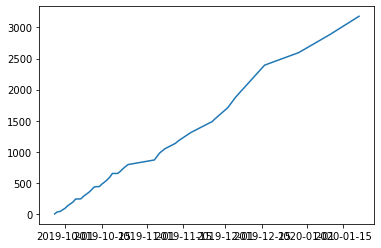

In [8]:
date_rng = pd.date_range(start='09/27/2019', end='09/27/2022', freq='D')
full_data=data_interp.reindex(date_rng)
print(full_data)
plt.plot(full_data)
plt.show()

# Plot data with linear projection
Plot a line between 1st day and today, with a linear projection to last day of lease.

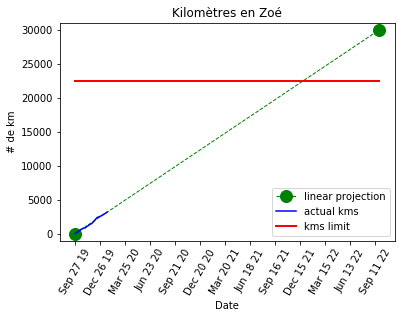

In [9]:
from datetime import date

data_line=data_interp.iloc[[0,-1]] #on garde le 1er point et le dernier point

def get_data_for_linear_projection(intermediate_point):
    d0 = date(2019, 9, 27) #date origine du lease
    d1 = date(2022, 9, 27) #date fin du lease
    d2 = intermediate_point.index[-1].date() #date du 2e point
    delta = d1 - d0 #nbre de jours du contrat
    delta2 = d2 - d0 #nbre de jours à date
    d = pd.DataFrame(0.0, index=np.arange(delta.days+1), columns=['kms'])
    pente = intermediate_point.kms[-1]/delta2.days
    for i in range(delta.days+1):
        kms=i*pente
        d['kms'][i]=kms
    return d

data_line=get_data_for_linear_projection(data_line)
data_line=data_line.set_index(date_rng)

plt.plot([data_line.index[0], data_line.index[-1]], [0,data_line.kms[-1]],color='green', marker='o', linestyle='dashed', linewidth=1, markersize=12, label='linear projection')
plt.plot(full_data, color='blue', label='actual kms')
plt.plot([data_line.index[0], data_line.index[-1]], [22500,22500],color='red',linewidth=2, label='kms limit')
plt.ylim(-1000,max(22500,data_line.kms[-1])+1000)

plt.xlabel('Date')
plt.ylabel('# de km')
plt.legend(loc='lower right')
plt.title('Kilomètres en Zoé')

date_enX=data_line.index[::90] # tous les 90 jours
labels_date=date_enX.strftime('%b %d %y') # mois et jour
plt.xticks(date_enX,labels_date,rotation=60)

plt.show()



## Interpretation of linear projection
Projected kms
if > limit, estimation of extra kms and at which date

In [10]:
print("Projection linéaire sur 37 mois : %3.1f kms."%data_line.kms[-1])
if (data_line.kms[-1] > 22500):
    print("   Dépassement de %3.1f kms commencé le %s." % ((data_line.kms[-1]-22500), data_line[data_line.kms > 22500].index[0].strftime("%d-%b-%Y")))

#trouver à quel date on est à 22500

Projection linéaire sur 37 mois : 30045.5 kms.
   Dépassement de 7545.5 kms commencé le 26-Dec-2021.


# Gradient descent to calculate linear regression

Essayer de faire une animation de type SGD vu dans http://localhost:8889/notebooks/lesson2-sgd.ipynb (fastai lesson 2)

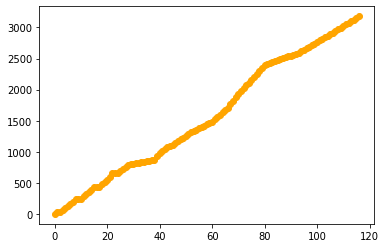

In [11]:
x=(data_interp.index-pd.Timestamp('2019-09-27')).days
y=data_interp.kms.values
plt.scatter(x, y,  c='orange')

m=len(x)

X=np.array([np.ones(m),x])
X=np.transpose(X)
theta=np.zeros((2,1))

# Some gradient descent settings
iterations = 1500;
alpha = 0.01;

## Fonction de coût

In [12]:
def computeCost(X,y,theta):
    m=len(y)
    theta=theta.reshape(2,1)
    y=y.reshape(m,1)
    J=0;
    squareError=np.square(X@theta-y)
    J=np.sum(squareError)/(2*m)
    return(J)
theta=np.zeros((2,1))    
print("Cout: ",theta,computeCost(X,y,theta))
theta=np.array([-1,2])
print("Cout: ",theta,computeCost(X,y,theta))

Cout:  [[0.]
 [0.]] 1704379.6986382983
Cout:  [-1  2] 1467307.4735670728


## Descente de gradient

In [13]:
from IPython.core.debugger import set_trace

def gradientDescent(X,y,theta,alpha,num_iters):
    m=len(y)
    theta=theta.reshape(2,1)
    y=y.reshape(m,1)
    J_history=np.zeros((num_iters,1))
    for i in range(num_iters):
        newtheta0=theta[0]-alpha*np.sum( (X@theta-y) * X[:,0] ) / m
        newtheta1=theta[1]-alpha*np.sum( (X@theta-y) * X[:,1] ) / m
        theta=np.array([newtheta0, newtheta1]).reshape(2,1)
        J_history[i]=computeCost(X,y,theta)
    return theta, J_history

theta=np.array([-1,2])
alpha=0.000001
theta, J_history = gradientDescent(X,y,theta,alpha,iterations)
print(theta, J_history)

[[-0.56530524]
 [27.21229601]] [[549344.4067667 ]
 [209010.75555521]
 [ 82150.27543081]
 ...
 [  4135.09931968]
 [  4135.09931968]
 [  4135.09931968]]


## Vitesse de convergence SGD

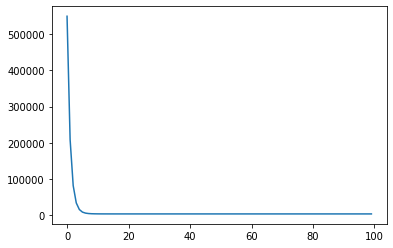

In [14]:
plt.plot(J_history[:100])
#on arrete si on ne decroit pas sensiblement --> sûrement adapter alpha (alpha=alpha/10)
assert(J_history[-1]<J_history[0]/10)

## On visualise la regression linéaire

Text(0.5, 1.0, 'Prédiction régression: 29851.3 kms sur 37 mois')

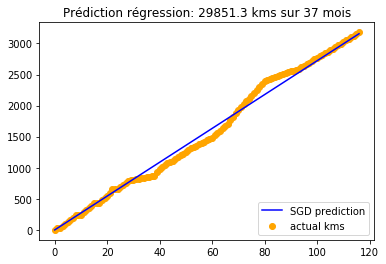

In [15]:
#on caclule les 2 points
x_line=[0,x[-1]]
y_line=[theta[0],theta[0]+theta[1]*x[-1]]
prediction_km=theta[0]+theta[1]*len(data_line)
Title='Prédiction régression: '+np.format_float_positional(prediction_km[0],precision=1)+' kms sur 37 mois'

plt.scatter(x, y,  c='orange', label='actual kms')
plt.plot(x_line, y_line, c='blue', label='SGD prediction')
plt.legend(loc='lower right')
plt.title(Title)


On conserve projection linéaire et régression linéaire.

In [16]:
#on met les projections et regression dans un dataframe df_stockage_projection
print(prediction_km[0])
print(data_line.kms[-1])

df_stockage_projection=pd.DataFrame([[data_line.kms[-1],prediction_km[0]]],columns=['Projection','Regression'])
df_stockage_projection['date']=pd.to_datetime('today').replace(hour=0, minute=0, second=0, microsecond=0)
df_stockage_projection=df_stockage_projection.set_index('date')
print(df_stockage_projection.head())


29851.323416009443
30045.51724137931
              Projection    Regression
date                                  
2020-01-21  30045.517241  29851.323416


On recharge l'historique des projections linéaire et régressions linéaire.<br>
On ajoute les dernières valeurs. (on ecrase les précédentes au besoin)

In [17]:
df_historique=pd.read_csv('data/historique_predictions.csv',index_col=0,parse_dates=True)
df_historique=df_historique.append(df_stockage_projection)
df_historique=df_historique.reset_index().drop_duplicates(subset='date',keep='last').set_index('date')
df_historique.tail(5)

,Projection,Regression
date,,
2019-12-02,28396.363636,27933.449843
2019-12-05,29862.028986,28059.789057
2019-12-16,32784.100000,28961.963148
2020-01-10,30145.219048,29791.299710
2020-01-21,30045.517241,29851.323416


In [18]:
df_historique.to_csv('data/historique_predictions.csv') 

## On trace les valeurs de projection linéaire et régression, ainsi que la limite.

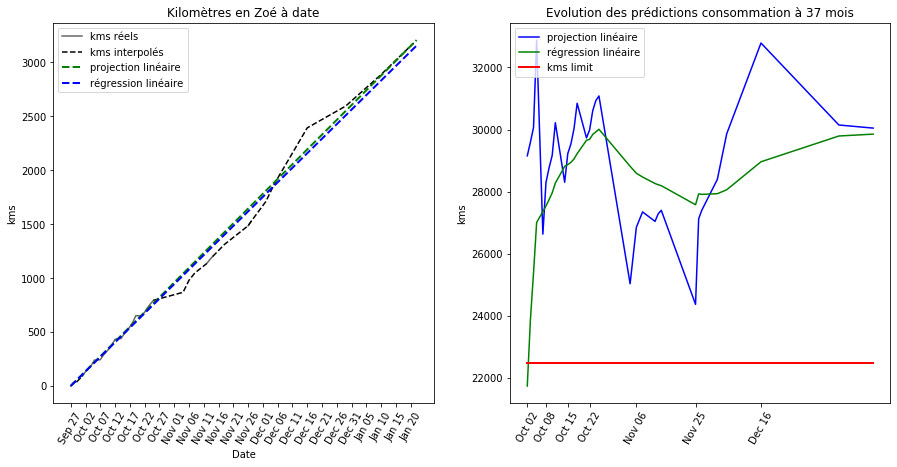

In [19]:
plt.figure(figsize=(15, 7))
plt.subplot(1,2,2)

plt.plot(df_historique.index, df_historique.Projection, label='projection linéaire', color='blue')
plt.plot(df_historique.index, df_historique.Regression, label='régression linéaire', color='green')
plt.plot(df_historique.index, 22500*np.ones(len(df_historique.Regression)),color='red',linewidth=2, label='kms limit')

date_enX=df_historique.index[::5] # tous les 5 jours
labels_date=date_enX.strftime('%b %d') # mois et jour
plt.xticks(date_enX,labels_date,rotation=60)
plt.ylabel('kms')
plt.legend(loc='upper left')
plt.title('Evolution des prédictions consommation à 37 mois')


plt.subplot(1,2,1)
#en noir les valeurs connues
plt.plot(data.index[::1], data_interp[~missing_values], color='k', alpha=.6, label='kms réels')
plt.xlabel('Date')
date_enX=data.index[::5] # tous les 5 jours
labels_date=date_enX.strftime('%b %d') # mois et jour
plt.ylabel(list(data.columns)[0])
plt.title('Kilomètres en Zoé à date')
# Now plot the interpolated values on top in red
new_missing=extend_missing(missing_values)
plt.plot(data.index[::1], data_interp[new_missing],color='k', linestyle='dashed', label='kms interpolés')
plt.xticks(date_enX,labels_date,rotation=60)
dernier_jour_calcule=len(data.index)
plt.plot([data_line.index[0], data_line.index[dernier_jour_calcule]], [0,data_line.kms[dernier_jour_calcule]],color='green', linestyle='dashed', linewidth=2, label='projection linéaire')
#on caclule les 2 points
x_line=[0,x[-1]]
y_line=[theta[0],theta[0]+theta[1]*x[-1]]
x_line_date=[data_line.index[0], data_line.index[dernier_jour_calcule]]
plt.plot(x_line_date, y_line, c='blue', linestyle='dashed',  linewidth=2,label='régression linéaire')

plt.legend(loc='upper left')


plt.show()